In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Egyéni eredmények és klaszterek összekapcsolása (results_checkpoint.csv  +  user_clusters.csv) = > results_checkpoint_with_clusters.csv
results_df = pd.read_csv("lstm_egyeni/results_checkpoint.csv")
clusters_df = pd.read_csv("cluster/user_clusters.csv")

results_w_cluster = results_df.merge(clusters_df, on="uid", how="left")

# új CSV mentése
results_w_cluster.to_csv("results_checkpoint_with_clusters.csv", index=False)
print("results_checkpoint_with_clusters.csv létrehozva!")

results_checkpoint_with_clusters.csv létrehozva!


In [2]:
# --- Beolvasás ---
cluster_df = pd.read_csv("cluster/results_clusters.csv")
checkpoint_df = pd.read_csv("results_checkpoint_with_clusters.csv")

Súlyozott átlagos accuracy (egyéni):   0.2509
Súlyozott átlagos top5_accuracy (egyéni): 0.4979
Átlagos accuracy (csoportos):           0.2577
Átlagos top5_accuracy (csoportos):      0.5794


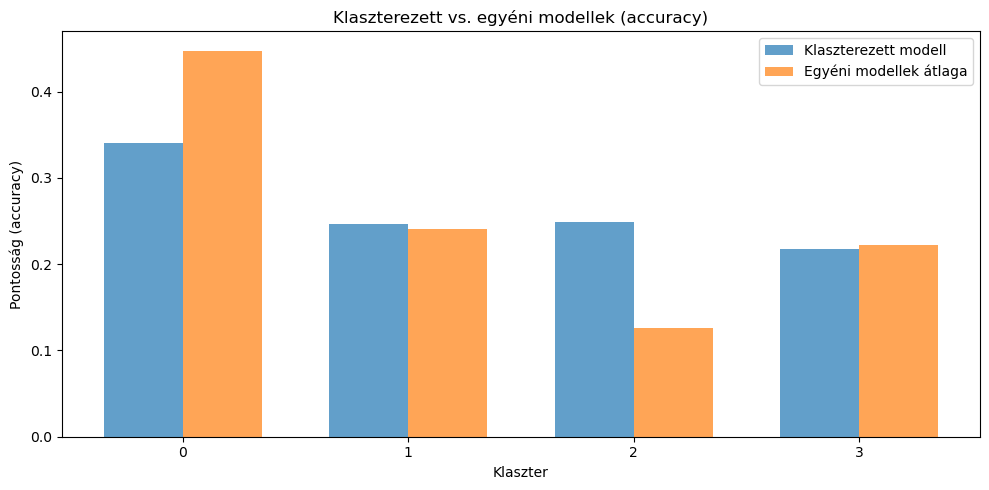

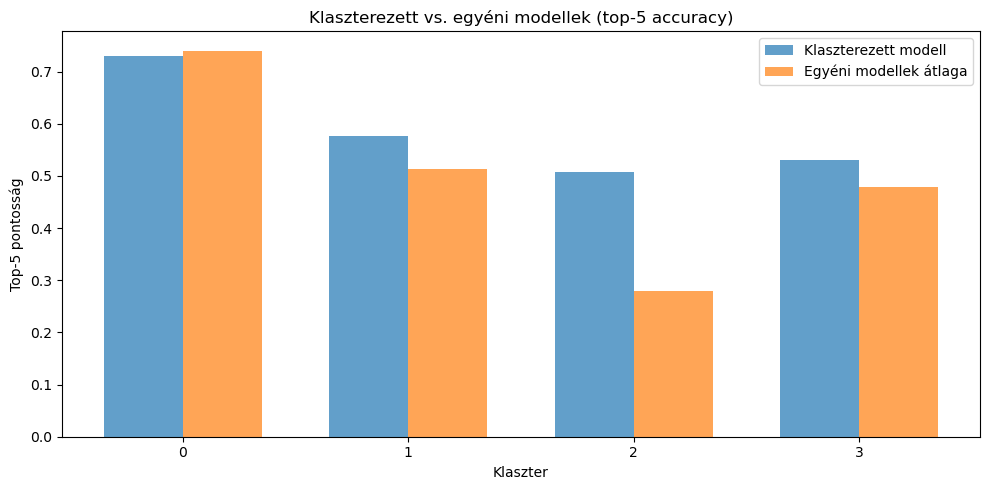

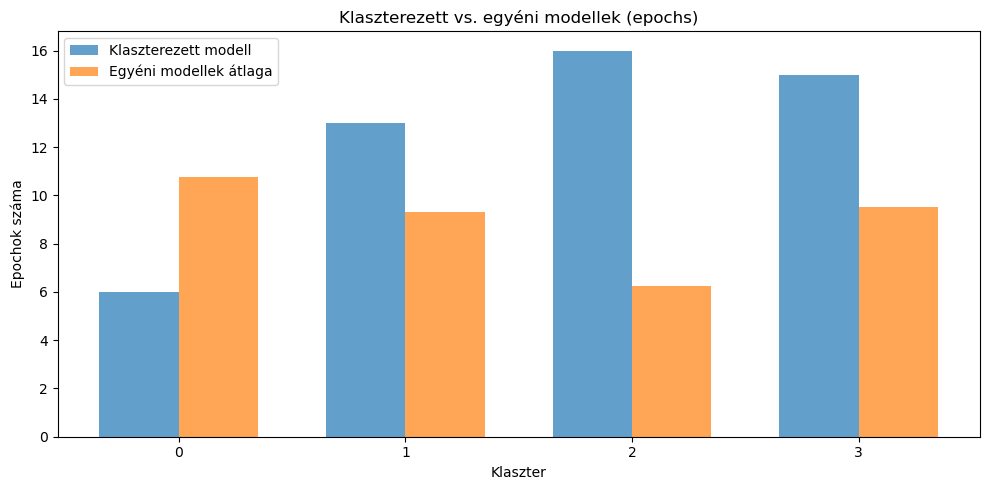

In [10]:
# ===============================
# VIZUALIZÁCIÓK – új verzió
# ===============================

# --- Aggregálás klaszterenként ---
cluster_stats = (
    checkpoint_df.groupby("cluster")
    .agg(
        users_in_cluster=("uid", "count"),
        mean_acc=("accuracy", "mean"),
        mean_top5=("top5_accuracy", "mean"),
        mean_train_acc=("train_accuracy", "mean"),
        mean_val_acc=("val_accuracy", "mean"),
        mean_test_acc=("test_accuracy", "mean"),
        mean_train_loss=("final_train_loss", "mean"),
        mean_val_loss=("final_val_loss", "mean"),
        mean_best_val_loss=("best_val_loss", "mean"),
        mean_epochs=("epochs_ran", "mean"),
        mean_best_epoch=("best_epoch", "mean"),
        mean_num_classes=("num_classes", "mean")
    )
    .reset_index()
)

# --- Súlyozott átlagok (egyéni modellek) ---
total_users = cluster_stats["users_in_cluster"].sum()
weighted_acc = (cluster_stats["mean_acc"] * cluster_stats["users_in_cluster"]).sum() / total_users
weighted_top5 = (cluster_stats["mean_top5"] * cluster_stats["users_in_cluster"]).sum() / total_users

# --- Súlyozott átlagok (csoportos / klaszterezett modellek) ---
weighted_acc_cluster = (cluster_df["accuracy"] * cluster_stats["users_in_cluster"]).sum() / total_users
weighted_top5_cluster = (cluster_df["top5_accuracy"] * cluster_stats["users_in_cluster"]).sum() / total_users

# --- Kiíratás ---
print(f"Súlyozott átlagos accuracy (egyéni):   {weighted_acc:.4f}")
print(f"Súlyozott átlagos top5_accuracy (egyéni): {weighted_top5:.4f}")
print(f"Átlagos accuracy (csoportos):           {weighted_acc_cluster:.4f}")
print(f"Átlagos top5_accuracy (csoportos):      {weighted_top5_cluster:.4f}")

# --- Merge a klaszter jellemzőkkel ---
compare_df = pd.merge(cluster_df, cluster_stats, on="cluster", how="inner")

# --- Különbségek kiszámítása ---
compare_df["acc_diff"] = compare_df["accuracy"] - compare_df["mean_acc"]
compare_df["top5_diff"] = compare_df["top5_accuracy"] - compare_df["mean_top5"]
compare_df["val_loss_diff"] = compare_df["final_val_loss"] - compare_df["mean_val_loss"]
compare_df["train_loss_diff"] = compare_df["final_train_loss"] - compare_df["mean_train_loss"]
compare_df["epochs_diff"] = compare_df["epochs_ran"] - compare_df["mean_epochs"]

# --- GRAFIKONOK ---
bar_width = 0.35
x = range(len(compare_df))

#  Accuracy összevetés
plt.figure(figsize=(10,5))
plt.bar(x, compare_df["accuracy"], width=bar_width, label="Klaszterezett modell", alpha=0.7)
plt.bar([i + bar_width for i in x], compare_df["mean_acc"], width=bar_width, label="Egyéni modellek átlaga", alpha=0.7)
plt.xticks([i + bar_width/2 for i in x], compare_df["cluster"])
plt.xlabel("Klaszter")
plt.ylabel("Pontosság (accuracy)")
plt.title("Klaszterezett vs. egyéni modellek (accuracy)")
plt.legend()
plt.tight_layout()
plt.show()

# Top-5 accuracy összevetés
plt.figure(figsize=(10,5))
plt.bar(x, compare_df["top5_accuracy"], width=bar_width, label="Klaszterezett modell", alpha=0.7)
plt.bar([i + bar_width for i in x], compare_df["mean_top5"], width=bar_width, label="Egyéni modellek átlaga", alpha=0.7)
plt.xticks([i + bar_width/2 for i in x], compare_df["cluster"])
plt.xlabel("Klaszter")
plt.ylabel("Top-5 pontosság")
plt.title("Klaszterezett vs. egyéni modellek (top-5 accuracy)")
plt.legend()
plt.tight_layout()
plt.show()

# Epochszámok összevetése
plt.figure(figsize=(10,5))
plt.bar(x, compare_df["epochs_ran"], width=bar_width, label="Klaszterezett modell", alpha=0.7)
plt.bar([i + bar_width for i in x], compare_df["mean_epochs"], width=bar_width, label="Egyéni modellek átlaga", alpha=0.7)
plt.xticks([i + bar_width/2 for i in x], compare_df["cluster"])
plt.xlabel("Klaszter")
plt.ylabel("Epochok száma")
plt.title("Klaszterezett vs. egyéni modellek (epochs)")
plt.legend()
plt.tight_layout()
plt.show()



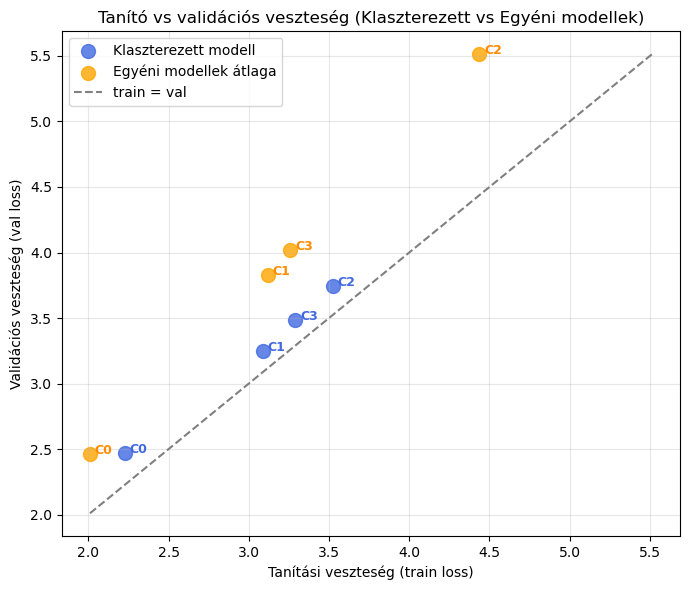

In [4]:
# Train vs Validation loss
plt.figure(figsize=(7,6))

# Pontok
plt.scatter(compare_df["final_train_loss"], compare_df["final_val_loss"],
            s=100, alpha=0.8, color="royalblue", label="Klaszterezett modell")
plt.scatter(compare_df["mean_train_loss"], compare_df["mean_val_loss"],
            s=100, alpha=0.8, color="orange", label="Egyéni modellek átlaga")

# Átló (train ≈ val)
min_loss = min(compare_df["final_train_loss"].min(), compare_df["mean_train_loss"].min())
max_loss = max(compare_df["final_val_loss"].max(), compare_df["mean_val_loss"].max())
plt.plot([min_loss, max_loss], [min_loss, max_loss],
         color="gray", linestyle="--", linewidth=1.5, label="train = val")

# Klaszter feliratok
for _, row in compare_df.iterrows():
    plt.text(row["final_train_loss"] + 0.03, row["final_val_loss"],
             f"C{int(row['cluster'])}", color="royalblue", fontsize=9, weight="bold")
    plt.text(row["mean_train_loss"] + 0.03, row["mean_val_loss"],
             f"C{int(row['cluster'])}", color="darkorange", fontsize=9, weight="bold")

# Tengelyek, címek
plt.xlabel("Tanítási veszteség (train loss)")
plt.ylabel("Validációs veszteség (val loss)")
plt.title("Tanító vs validációs veszteség (Klaszterezett vs Egyéni modellek)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


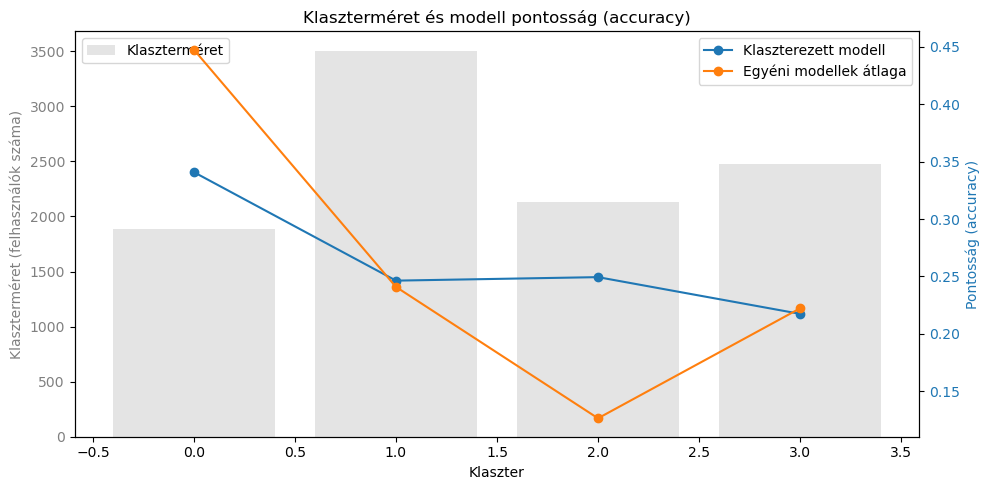

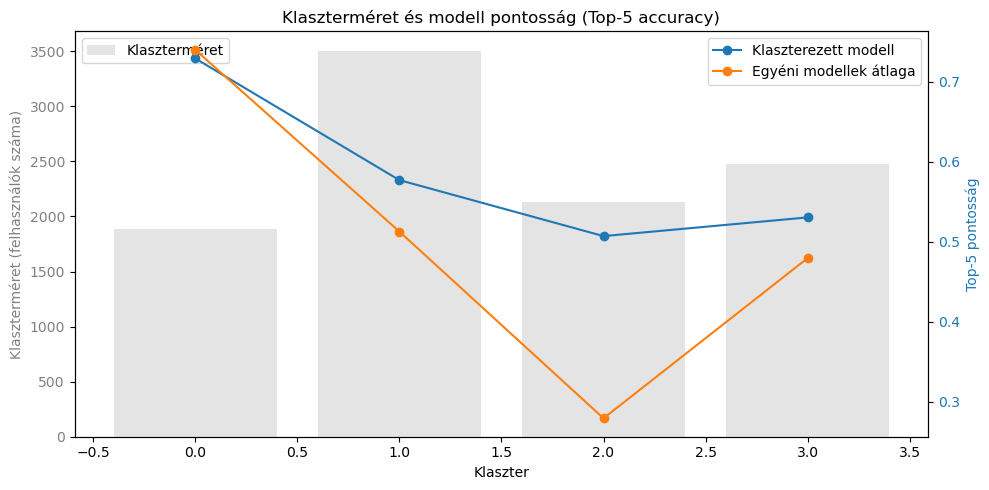

In [5]:
# ===============================
# VIZUALIZÁCIÓK 2.
# ===============================

fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()

# Bar chart: klaszterméret
ax1.bar(compare_df["cluster"], compare_df["users_in_cluster"], color="lightgray", alpha=0.6, label="Klaszterméret")

# Line plot: pontosságok
ax2.plot(compare_df["cluster"], compare_df["accuracy"], marker="o", label="Klaszterezett modell", color="tab:blue")
ax2.plot(compare_df["cluster"], compare_df["mean_acc"], marker="o", label="Egyéni modellek átlaga", color="tab:orange")

ax1.set_xlabel("Klaszter")
ax1.set_ylabel("Klaszterméret (felhasználók száma)", color="gray")
ax2.set_ylabel("Pontosság (accuracy)", color="tab:blue")
ax1.tick_params(axis='y', labelcolor="gray")
ax2.tick_params(axis='y', labelcolor="tab:blue")

# accuracy ábra
plt.title("Klaszterméret és modell pontosság (accuracy)")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()

# 2. ÁBRA TOP5


fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()

# klaszterméret felvétele az ábrára
ax1.bar(compare_df["cluster"], compare_df["users_in_cluster"],
        color="lightgray", alpha=0.6, label="Klaszterméret")

# --- Kék és narancs pontvonal: top-5 pontosság ---
ax2.plot(compare_df["cluster"], compare_df["top5_accuracy"],
         'o-', color="tab:blue", label="Klaszterezett modell")
ax2.plot(compare_df["cluster"], compare_df["mean_top5"],
         'o-', color="tab:orange", label="Egyéni modellek átlaga")

# --- Címkék és stílus ---
ax1.set_xlabel("Klaszter")
ax1.set_ylabel("Klaszterméret (felhasználók száma)", color="gray")
ax2.set_ylabel("Top-5 pontosság", color="tab:blue")

ax1.tick_params(axis='y', labelcolor="gray")
ax2.tick_params(axis='y', labelcolor="tab:blue")

## Top-5 accuracy ábra
plt.title("Klaszterméret és modell pontosság (Top-5 accuracy)")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

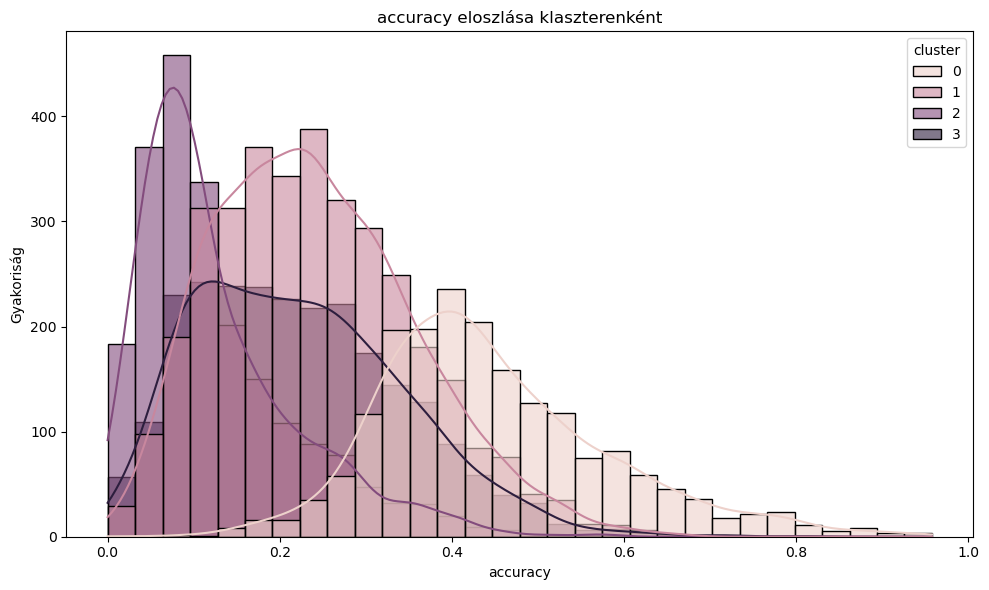

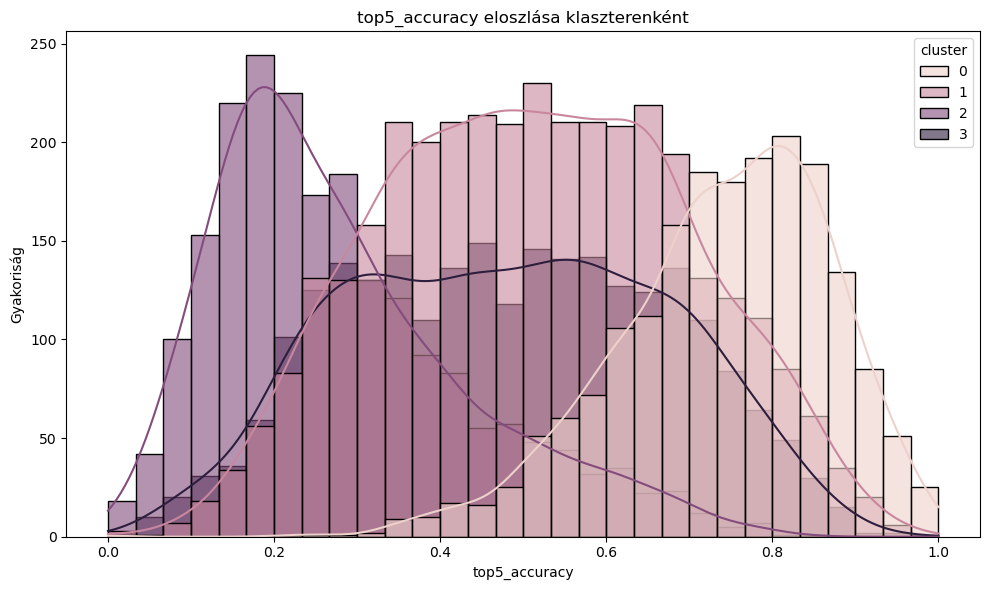

In [ ]:


# Csak a főbb metrikák, például accuracy és val_loss
metrics = ["accuracy", "top5_accuracy"]

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=checkpoint_df, x=metric, hue="cluster", kde=True, bins=30, alpha=0.6)
    #plt.title(f"{metric} eloszlása klaszterenként")
    plt.xlabel(metric)
    plt.ylabel("Gyakoriság")
    plt.tight_layout()
    plt.show()


In [9]:

cluster_stats

,cluster,users_in_cluster,mean_acc,mean_top5,mean_train_acc,mean_val_acc,mean_test_acc,mean_train_loss,mean_val_loss,mean_best_val_loss,mean_epochs,mean_best_epoch,mean_num_classes
0,0,1886,0.447475,0.740182,0.472531,0.449539,0.447475,2.009801,2.464954,2.403928,10.752916,7.803818,123.789502
1,1,3506,0.240924,0.512896,0.280269,0.253699,0.240924,3.117059,3.827997,3.714499,9.319167,6.349401,188.407017
2,2,2127,0.126491,0.279394,0.156909,0.141347,0.126491,4.437388,5.512780,5.204806,6.252938,3.252938,384.428303
3,3,2481,0.222235,0.479704,0.261675,0.233385,0.222235,3.258484,4.018157,3.891903,9.503023,6.547360,200.905280
